In [1]:
import numpy as np
import pandas as pd
import time
import sys
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc

In [2]:
#get data
in_file = '../../merge/Ulz_cancer_detection_results_merged.txt'
feature_type = 'Ulz'

metadata_columns = ['bam_name','sample_type','cancer_present']

data = pd.read_csv(in_file, sep='\t')

data = data.set_index('sample')
data['status'] = data['cancer_present']

#get only the training samples used in delfi
training_samples = pd.read_csv("../../../../metadata/cancer_detection/delfi_training_samples.txt", header=None)
data = data[data.index.isin(training_samples[0])].copy()

print(len(data))
print(data['sample_type'].value_counts())


423
Healthy              215
Breast_Cancer         54
Pancreatic_Cancer     34
Ovarian_Cancer        28
Gastric_cancer        27
Colorectal_Cancer     27
Bile_Duct_Cancer      25
Lung_Cancer           12
Duodenal_Cancer        1
Name: sample_type, dtype: int64


In [3]:
#view data
data.head()

,ADNP,AEBP2,AhR,Androgen,AP-2&#945;,AP-2&#947;,AP-4,ARID1A,ARID1B,ARID2,...,ZSCAN16,ZSCAN22,ZSCAN2,ZSCAN5A,ZSCAN5D,ZXDC,bam_name,sample_type,cancer_present,status
sample,,,,,,,,,,,,,,,,,,,,,
Healthy_CGPLH640,0.246933,0.246460,0.154958,0.206862,0.231068,0.164809,0.264694,0.192881,0.178545,0.233550,...,0.352748,0.204694,0.177236,0.206160,0.199835,0.151435,PGDX18259P_WGS.sorted_processed,Healthy,0,0
Breast_Cancer_CGPLBR24,0.197544,0.292149,0.156324,0.183372,0.197434,0.140286,0.401576,0.181430,0.199875,0.162787,...,0.311026,0.254315,0.151788,0.155140,0.256196,0.175019,PGDX2750P_WGS_X1.sorted_processed,Breast_Cancer,1,1
Colorectal_Cancer_CGCRC292,0.209211,0.225146,0.251445,0.213004,0.172528,0.188227,0.273997,0.235666,0.187254,0.182486,...,0.362596,0.189254,0.179967,0.245128,0.219038,0.248635,PGDX5882P_WGS_processed_downsamp,Colorectal_Cancer,1,1
Colorectal_Cancer_CGCRC341,0.259626,0.238307,0.164468,0.194450,0.123776,0.182936,0.421222,0.137561,0.165446,0.147863,...,0.340457,0.137220,0.155708,0.163189,0.278206,0.180995,PGDX8828P_WGS.sorted_processed,Colorectal_Cancer,1,1
Healthy_CGPLH324,0.219229,0.307641,0.150478,0.239262,0.213007,0.203533,0.464607,0.204062,0.130070,0.184918,...,0.322466,0.202766,0.191341,0.201426,0.238394,0.204629,PGDX18251P_WGS.sorted_processed,Healthy,0,0


In [4]:
#get a list of all possible features
features = data.columns.drop(['status']+metadata_columns)

#these two should be the seame
print(len(features))
print(len(features[features.str.contains('fft_10_magnitude')])*3)

504
0


In [5]:
#scale data
scaler = StandardScaler()
scaler.fit(data[features])
data[features] = scaler.transform(data[features])
data[features].mean()

ADNP          3.015712e-16
AEBP2         2.740125e-16
AhR          -1.246442e-15
Androgen     -5.028812e-16
AP-2&#945;    5.123299e-16
                  ...     
ZSCAN22       7.978908e-17
ZSCAN2       -3.768984e-16
ZSCAN5A       1.921237e-16
ZSCAN5D      -2.099713e-16
ZXDC         -7.320779e-16
Length: 504, dtype: float64

In [6]:
#Leave one out nested cross validation
hyperparameters = {'C': [0.00001, 0.0001, 0.001,0.01,0.1,1,10,100]}

start_time = time.time()
n_iter = 1000

probabilities = pd.DataFrame(index=data.index)
c_vals = []
coefs = pd.DataFrame(index=features)

# Loop for each iteration
for i in range(n_iter):
    if i%50==0:
        print(i, time.time()-start_time)
        sys.stdout.flush()
    
    #bootstrap a training set with replacement
    training = data.sample(len(data), replace = True, random_state = i+100)
    
    #the test set is all samples that aren't seen in the training data
    test = data[~(data.index.isin(training.index))]
        
    #10 fold cross validation on the training set
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = i+100) 

    model = LogisticRegression(class_weight='balanced', max_iter=500)
    search = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=cv, n_jobs = 1)
    search.fit(training[features], training['status'])
    best_C = search.best_params_['C']
    
    #train a new model on the full training dataset (is this the same as refit...?)
    model = LogisticRegression(class_weight='balanced', max_iter=500, C=best_C)
    model.fit(training[features], training['status'])

    #predict the test data
    pred = model.predict(test[features])
    prob = model.predict_proba(test[features])

    
    #collect metrics
    current_output = pd.DataFrame(test[['status']])#.reset_index()
    current_output['probability']=prob[:,1]
    
    #save results
    probabilities[i] = current_output['probability']
    c_vals.append(best_C)
    coefs[i] = pd.Series(model.coef_[0], index = features)

probabilities = probabilities.merge(data[metadata_columns+['status']], left_index=True, right_index=True)

0 0.001032114028930664
50 41.770954847335815
100 82.44109892845154
150 124.52376103401184
200 166.0621919631958
250 208.78111600875854
300 249.60822701454163
350 295.57288098335266
400 337.589271068573
450 382.9674479961395
500 426.0689151287079
550 469.11658000946045
600 510.70854902267456
650 553.1234149932861
700 594.986368894577
750 638.6877040863037
800 682.2249839305878
850 726.5762100219727
900 769.9527950286865
950 812.1654019355774


In [7]:
probabilities.to_csv(feature_type+'_results/probabilities.txt', sep='\t')
pd.Series(c_vals).to_csv(feature_type+'_results/c_values.txt', sep='\t', header = False, index=False)
coefs.to_csv(feature_type+'_results/coefs.txt', sep='\t')

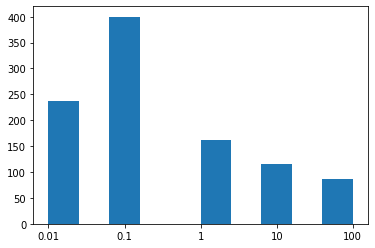

In [8]:
plt.hist([str(m) for m in sorted(c_vals)])
plt.savefig(feature_type+'_results/cvals.pdf')